# Rozdział 3 - MNIST

### 1. Importowanie danych

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

In [2]:
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [3]:
X, y = mnist["data"].to_numpy(), mnist["target"].to_numpy()

In [4]:
print("X.shape: ", X.shape)
print("y.shape: ", y.shape)

X.shape:  (70000, 784)
y.shape:  (70000,)


### 2. Wizualizacja danych

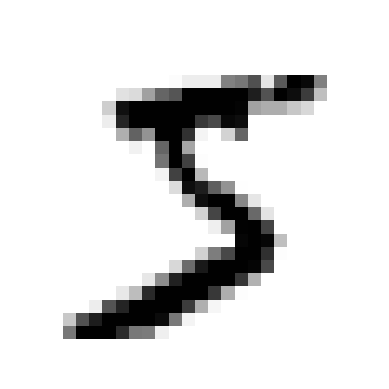

In [18]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis('off')
plt.show()

In [122]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

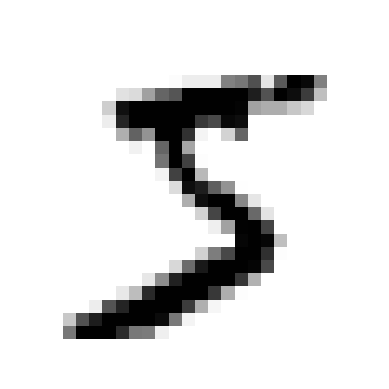

In [123]:
plot_digit(some_digit)

In [19]:
y[0]

5

In [20]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

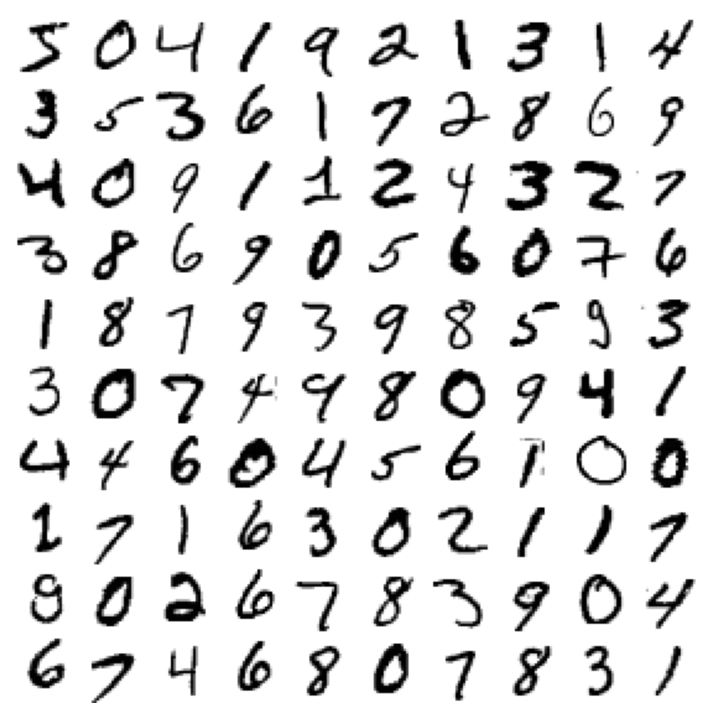

In [22]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

### 3. Konwersja typów i tworzenie zbioru testowego

<b>3.1 Konwersja typów (na int)</b>

In [7]:
import numpy as np

y = y.astype(np.uint8)

In [8]:
y[0]

5

<b>3.2 Tworzenie zbioru testowego</b>

Zestaw danych MNIST został już uprzednio potasowany, dlatego wystarczy jedynie podzielić dane na dwa zbiory

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 4. Uczenie klasyfikatora binarnego

Na początku zadanie zostanie uproszczone. Celem jest rozpoznanie cyfry "5", albo stwierdzenie, że dana cyfra nie jest "piątką".

<b>4.1 Tworzenie wektorów docelowych</b>

In [10]:
y_train_5 = (y_train == 5) # Wartość True dla piątek, False dla wszystkich pozostałych cyfr
y_test_5 = (y_test == 5)

<b>4.2 Trenowanie modelu</b>

In [44]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=420)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=420)

<b>4.3 Przykładowa predycja</b>

In [45]:
print("Predykcja: ", sgd_clf.predict([some_digit]))

Predykcja:  [ True]


### 5. Miary wydajności

<b>5.1 Pomiar dokładności</b>

##### 5.1.1 Sprawdzian krzyżowy - Scikit-Learn

In [46]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9694 , 0.96545, 0.95465])

##### 5.1.2 Sprawdzian krzyżowy - własna implementacja

In [47]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # umożliwia losowanie warstwowe

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9569
0.96085
0.9601


##### 5.1.3 Implementacja prostego klasyfikatora

Zaimplementowanie i wykorzystanie tego klasyfikatora ma pokazać, że dokładność nie stanowi dobrej miary wydajności klasyfikatorów

In [48]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [49]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Dokładność wynosi ok. 90% więc wydaje się bardzo dobra, jednakże w tym przypadku każda cyfra jest rozpoznana jako "niepiątka". Dodatkowo mamy do czynienia z wypaczonym zbiorem danych gdzie "5" stanowi jedynie 1/10 danych w zbiorze, dlatego dokładność wynosi ok. 90%.

<b>5.2 Macierz pomyłek</b>

##### 5.2.1 Wyznaczenie zbioru prognoz - sprawdzian krzyżowy

In [50]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

##### 5.2.2 Wyznaczenie macierzy pomyłek

In [51]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53141,  1438],
       [  772,  4649]])

<b>5.3 Precyzja i pełność</b>

In [52]:
from sklearn.metrics import precision_score, recall_score

prec = precision_score(y_train_5, y_train_pred) # PP/(PP + FP)
rec = recall_score(y_train_5, y_train_pred) # PP/(PP + FN)

print("Precyzja: ", prec)
print("Pełność: ", rec)

Precyzja:  0.7637588302940693
Pełność:  0.8575908503966058


<b>5.4 Wynik $F_{1}$</b>

In [53]:
from sklearn.metrics import f1_score

f1 = f1_score(y_train_5, y_train_pred)
print("F1: ", f1)

F1:  0.8079596802224539


<b>5.5 Kompromis pomiędzy precyzją a pełnością</b>

##### 5.5.1 Ręczny dobór progu dla przykładowej cyfry

In [54]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([731.87680986])

In [55]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [56]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

##### 5.5.2 Zależność pomiędzy precyzją i pełnością a progiem decyzyjnym

In [57]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [58]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

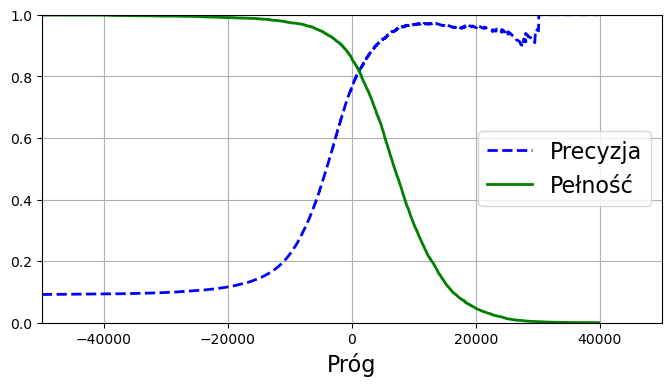

In [59]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precyzja", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Pełność", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Próg", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])



plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

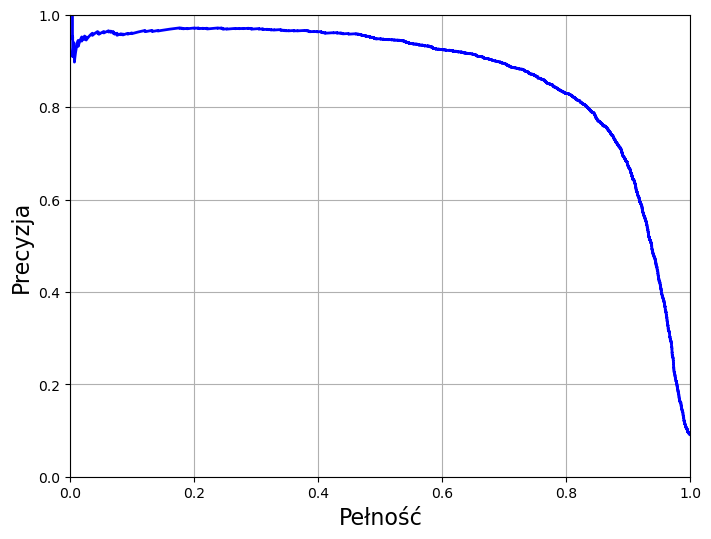

In [60]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Pełność", fontsize=16)
    plt.ylabel("Precyzja", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [64]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [65]:
y_train_pred_90 = (y_scores > threshold_90_precision)

In [71]:
precision_score(y_train_5, y_train_pred_90)

0.9003394762366634

In [72]:
recall_score(y_train_5, y_train_pred_90)

0.6849289798930087

##### 5.5.3 Wykres krzywej ROC

In [73]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

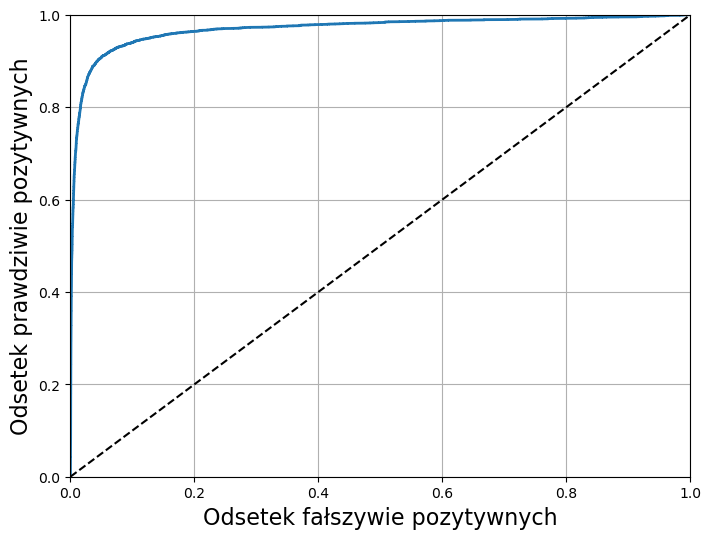

In [74]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # przerywana linia ukośna
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Odsetek fałszywie pozytywnych', fontsize=16)
    plt.ylabel('Odsetek prawdziwie pozytywnych', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [75]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9698204220281057

<b>5.6 Porównanie z modelem losowego lasu</b>

In [76]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=420)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [77]:
y_probas_forest

array([[0.21, 0.79],
       [0.99, 0.01],
       [0.99, 0.01],
       ...,
       [0.01, 0.99],
       [0.89, 0.11],
       [0.9 , 0.1 ]])

In [78]:
y_scores_forest = y_probas_forest[:, 1] # Wynik = prawdopodobieństwo przynależności do klasy pozytywnej
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

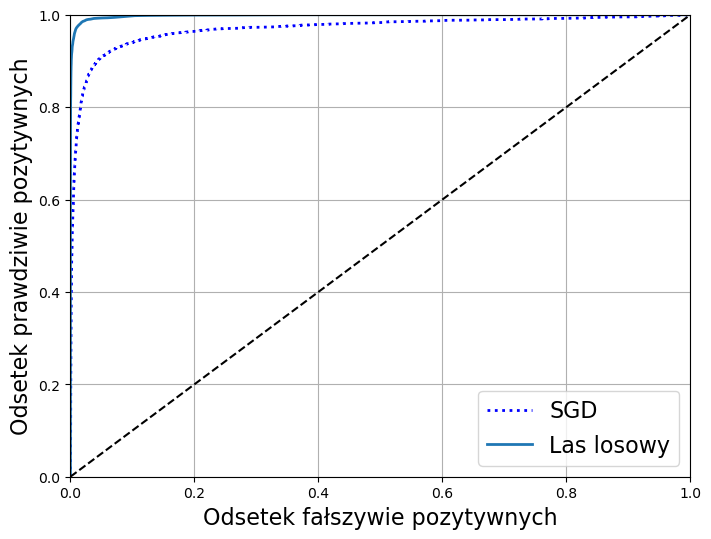

In [79]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Las losowy")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [80]:
roc_auc_score(y_train_5, y_scores_forest)

0.99836554064107

In [81]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [82]:
prec = precision_score(y_train_5, y_train_pred_forest) # PP/(PP + FP)
rec = recall_score(y_train_5, y_train_pred_forest) # PP/(PP + FN)

print("Precyzja: ", prec)
print("Pełność: ", rec)

Precyzja:  0.9908936891147818
Pełność:  0.8631248847076185


In [83]:
f1 = f1_score(y_train_5, y_train_pred_forest)
print("F1: ", f1)

F1:  0.9226067238489599


### 6. Klasyfikacja wieloklasowa

<b>6.1 Przegląd modeli</b>

##### 6.1.1 Maszyna wektorów nośnych SVC - OvO

In [86]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

array([5], dtype=uint8)

In [87]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [93]:
np.argmax(some_digit_scores)

5

In [94]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

##### 6.1.2 Maszyna wektorów nośnych SVC - OvR

In [95]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

KeyboardInterrupt: 

In [ ]:
some_digit_scores = ovr_clf.decision_function([some_digit])
some_digit_scores

##### 6.1.3 Klasyfikator SGD


In [96]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

KeyboardInterrupt: 

In [ ]:
sgd_clf.decision_function([some_digit])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

Po zastosowaniu skalowania danych wejściowych otrzymujemy:

In [99]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

<b>6.2 Analiza błędów</b>

In [101]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

/Users/adamdabkowski/opt/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


In [102]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5590,    0,   21,    6,    8,   44,   34,    6,  213,    1],
       [   1, 6403,   39,   23,    4,   44,    4,    8,  204,   12],
       [  27,   26, 5244,   95,   71,   28,   67,   38,  355,    7],
       [  22,   17,  119, 5239,    2,  207,   26,   40,  389,   70],
       [  12,   14,   47,   10, 5202,   11,   34,   26,  321,  165],
       [  28,   16,   33,  168,   52, 4452,   76,   17,  515,   64],
       [  29,   15,   43,    2,   42,   98, 5555,    5,  128,    1],
       [  20,    8,   52,   30,   50,   12,    3, 5714,  172,  204],
       [  18,   64,   48,   86,    3,  126,   24,   11, 5430,   41],
       [  24,   18,   29,   64,  120,   34,    1,  184,  357, 5118]])

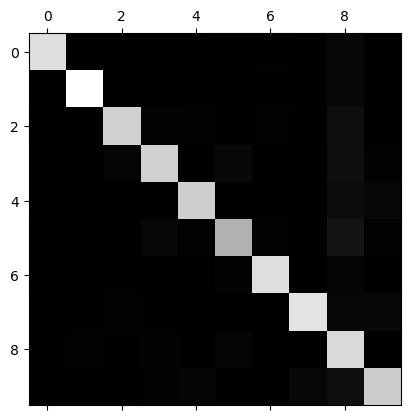

In [106]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Wiersze - rzeczywiste cyfry
Kolumny - rozpoznane cyfry

In [107]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

In [109]:
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

array([[9.43778491e-01, 0.00000000e+00, 3.54550059e-03, 1.01300017e-03,
        1.35066689e-03, 7.42866790e-03, 5.74033429e-03, 1.01300017e-03,
        3.59615060e-02, 1.68833361e-04],
       [1.48323939e-04, 9.49718185e-01, 5.78463364e-03, 3.41145061e-03,
        5.93295758e-04, 6.52625334e-03, 5.93295758e-04, 1.18659152e-03,
        3.02580837e-02, 1.77988727e-03],
       [4.53172205e-03, 4.36388050e-03, 8.80161128e-01, 1.59449480e-02,
        1.19167506e-02, 4.69956361e-03, 1.12453844e-02, 6.37797919e-03,
        5.95837529e-02, 1.17489090e-03],
       [3.58832164e-03, 2.77279400e-03, 1.94095580e-02, 8.54509868e-01,
        3.26211059e-04, 3.37628446e-02, 4.24074376e-03, 6.52422117e-03,
        6.34480509e-02, 1.14173870e-02],
       [2.05409106e-03, 2.39643958e-03, 8.04519000e-03, 1.71174255e-03,
        8.90448477e-01, 1.88291681e-03, 5.81992468e-03, 4.45053064e-03,
        5.49469360e-02, 2.82437521e-02],
       [5.16509869e-03, 2.95148497e-03, 6.08743774e-03, 3.09905921e-02,
   

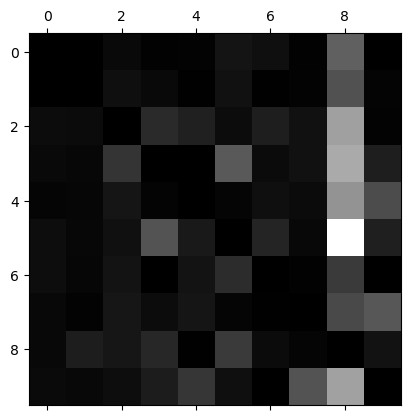

In [111]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [112]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

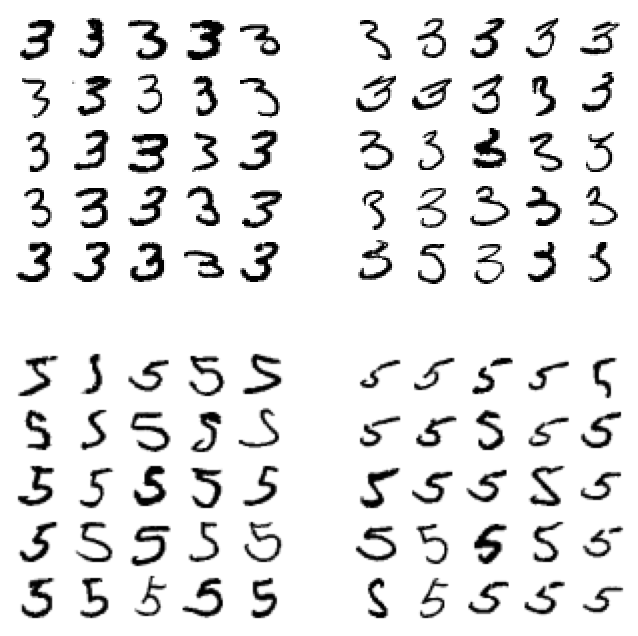

In [113]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### 7. Klasyfikacja wieloetykietowa

Zadanie polega na rozpoznawaniu czy dana cyfra jest równa (7, 8, 9) i czy jest nieparzysta.

In [114]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

y_multilabel = np.c_[y_train_large, y_train_odd]

In [115]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [116]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [117]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [118]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [119]:
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

### 8. Klasyfikacja wielowyjściowa

Zadanie polega na usuwaniu szumu z obrazów cyfr

<b>8.1 Zaszumianie danych</b>

In [120]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

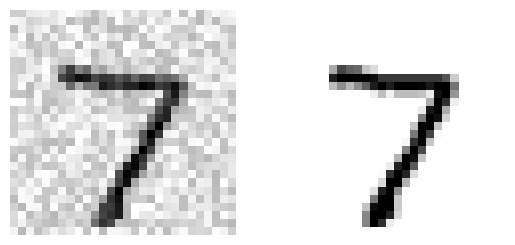

In [124]:
some_index = 0
plt.subplot(121);
plot_digit(X_test_mod[some_index])
plt.subplot(122);
plot_digit(y_test_mod[some_index])
plt.show()

In [125]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

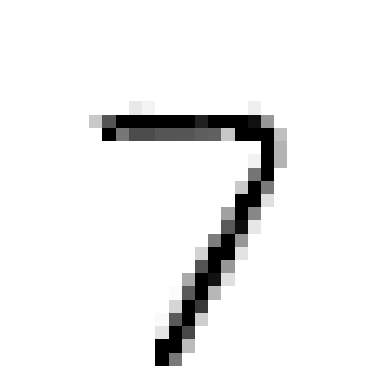

In [126]:
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)